# Fine tuning a network for a 5 class classifier Using Pytorch
A pretrained network is fine tuned in this question.
ResNet-18 has been used which is a convolutional neural network that is trained on more than a million
images from the ImageNet database [1]. The network is 18 layers deep and can classify images into 1000 object
categories, such as keyboard, mouse, pencil, and many animals. Linnaeus 5 dataset is used which consists of
five classes. There is a total of 1200 training images and 400 testing images.

For fine tuning, the approach consists of freezing the bottom layers as feature extraction layer works on
extracting valuable information from the images. Different classes can have different features, so retraining is
necessary for this layer. The first one is a simple classifier with one fully connected layer, and the second one
is a complex classifier with dropout regularization and batch-normalization. Dropout regularization is used to
avoid overfitting. The result of overfitting can be seen by comparing the training and testing accuracy. If you
have higher training accuracy and low testing accuracy, it can be a cause of overfitting.Overfitting refers to
a model that models the training data too well. Batchnormalization is used to normalize the input layer by
adjusting and scaling the activations. It increases the speed, performance, and stability of the model. I have
shown the result of the two models, with and without regularization and normalization

In [42]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [43]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

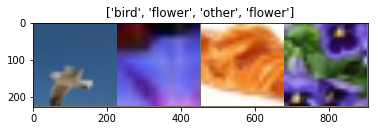

In [44]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [45]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [41]:
model_ft = models.resnet18(pretrained=True)

num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Sequential(
    
    nn.Dropout(0.2),
    nn.BatchNorm1d(num_ftrs),
    nn.Linear(num_ftrs, 5)
)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [6]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=4)


Epoch 0/3
----------
train Loss: 1.6791 Acc: 0.3371
val Loss: 1.5488 Acc: 0.4113

Epoch 1/3
----------
train Loss: 1.5629 Acc: 0.3902
val Loss: 1.2913 Acc: 0.5108

Epoch 2/3
----------
train Loss: 1.6635 Acc: 0.3939
val Loss: 1.5534 Acc: 0.5541

Epoch 3/3
----------
train Loss: 1.5160 Acc: 0.4242
val Loss: 1.3242 Acc: 0.5671

Training complete in 7m 16s
Best val Acc: 0.567100


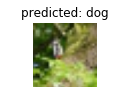

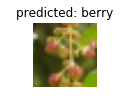

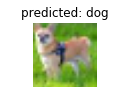

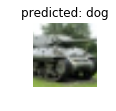

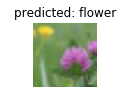

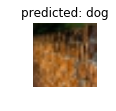

In [7]:
visualize_model(model_ft)

In [8]:
#ConvNet as fixed feature extractor

In [46]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Sequential(

    nn.Dropout(0.2),
    nn.BatchNorm1d(model_conv.fc.in_features),
    nn.Linear(model_conv.fc.in_features,5)
)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [35]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=5)


Epoch 0/4
----------
train Loss: 1.5377 Acc: 0.3674
val Loss: 1.3440 Acc: 0.4416

Epoch 1/4
----------
train Loss: 1.4480 Acc: 0.3826
val Loss: 1.2245 Acc: 0.4978

Epoch 2/4
----------
train Loss: 1.2440 Acc: 0.4811
val Loss: 1.1805 Acc: 0.5065

Epoch 3/4
----------
train Loss: 1.2664 Acc: 0.4962
val Loss: 1.1299 Acc: 0.5671

Epoch 4/4
----------
train Loss: 1.1863 Acc: 0.5076
val Loss: 1.1783 Acc: 0.5628

Training complete in 4m 14s
Best val Acc: 0.567100


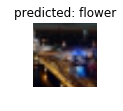

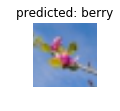

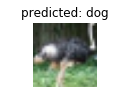

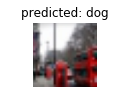

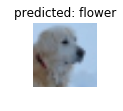

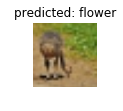

In [47]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [48]:
nb_classes = 9

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
plt.figure()

tensor([[ 9., 12.,  7., 13.,  3.,  0.,  0.,  0.,  0.],
        [ 9.,  7.,  9., 11.,  8.,  0.,  0.,  0.,  0.],
        [10., 10.,  7.,  5., 12.,  0.,  0.,  0.,  0.],
        [ 6., 13., 13.,  9., 14.,  0.,  0.,  0.,  0.],
        [16.,  6.,  4., 13.,  5.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [49]:
from sklearn.metrics import confusion_matrix

nb_classes = 9

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)



[[ 6 11  7 13  7]
 [11  9  8 11  5]
 [12  3  6 11 12]
 [12 12  7 10 14]
 [13  8  7  7  9]]


In [50]:

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

[13.63636364 20.45454545 13.63636364 18.18181818 20.45454545]


In [55]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix with drop-out regularization")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')    

Confusion matrix, without normalization
[[ 6 11  7 13  7]
 [11  9  8 11  5]
 [12  3  6 11 12]
 [12 12  7 10 14]
 [13  8  7  7  9]]


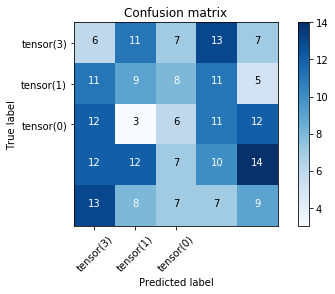

In [56]:
from sklearn import metrics
import itertools
cm = metrics.confusion_matrix(lbllist.numpy(), predlist.numpy())
plot_confusion_matrix((cm), classes )

In [57]:
def plot_normalizedconfusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix with drop-out regularization")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

Normalized confusion matrix with drop-out regularization
Normalized confusion matrix with drop-out regularization
[[0.13636364 0.25       0.15909091 0.29545455 0.15909091]
 [0.25       0.20454545 0.18181818 0.25       0.11363636]
 [0.27272727 0.06818182 0.13636364 0.25       0.27272727]
 [0.21818182 0.21818182 0.12727273 0.18181818 0.25454545]
 [0.29545455 0.18181818 0.15909091 0.15909091 0.20454545]]


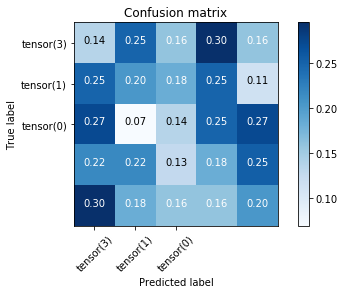

In [58]:
 print("Normalized confusion matrix with drop-out regularization")
plot_normalizedconfusion_matrix((cm), classes )


In [59]:
all_label_list = lbllist.tolist()
all_preds_list = predlist.tolist()

In [60]:
print(metrics.classification_report(all_label_list, all_preds_list, digits=3))

             precision    recall  f1-score   support

          0      0.111     0.136     0.122        44
          1      0.209     0.205     0.207        44
          2      0.171     0.136     0.152        44
          3      0.192     0.182     0.187        55
          4      0.191     0.205     0.198        44

avg / total      0.176     0.173     0.174       231

